state_size:  4
action_size:  2


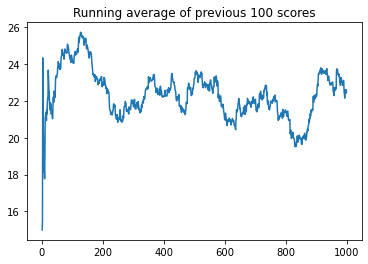

In [9]:
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import gym
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file='test'):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)
    
## Generate the Q values 
class Critic(nn.Module):
    ## Given the state, what is the action value for each ?
    def __init__(self, state_size, action_size, alpha=1e-04, fc_dim1=256, fc_dim2=256,):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        ## Assume output one rewards as the output
        self.linear1 = nn.Linear(state_size, fc_dim1)
        self.linear2 = nn.Linear(fc_dim1, fc_dim2)
        self.linear3 = nn.Linear(fc_dim2, action_size)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-5)
        self.loss_fun = nn.MSELoss()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, state):
        #Sate is numpy array
        #print ('State Critic: ', state.dim, state)
        x = torch.tensor(state.astype(float)).to(self.device)
        output = F.relu(self.linear1(x))
        output = F.relu(self.linear2(output))
        #display('State: ', state)
        #print (x)
        Qs = self.linear3(output)
        return Qs ##Output the each Q value for each action
    
class Agent():
    def __init__(self,gamma, env, model, episodes=50, epsilon=1, nsteps=50):
        self.gamma = gamma
        self.nsteps = nsteps
        self.eps_begin = 1
        self.eps_end = 0.1
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.model = model.double().to(self.device)
        self.episodes = episodes
        self.env = env
        self.epsilon = epsilon
        
        
    def pickActionEgreedy(self, best):
        if np.random.rand() < self.epsilon:
            return env.action_space.sample() #random 
        else:
            return best

    def train(self):
        t = 0
        rewards_list = []
        
        #print ('Shape return: ', s.shape)
                        
        for i in range(self.episodes):
            total_rewards = 0
            s = self.env.reset()  #Obtain the initial stare
            
                            ##Pick the action with epsilon-greddy wih the current policy
            best_action = torch.argmax(self.model(s.flatten())).to(self.device) #obtain the best action
            action = self.pickActionEgreedy(best_action.item()) #selection the action by applying the greedy alg
            
            done=False
            while not done:
                
                self.model.train()
                self.model.zero_grad()
                t = t+1
                alpha = 1 / t
                
                """
                if t < self.nsteps:
                    self.epsilon = self.epsilon - (self.eps_begin - self.eps_end) *(t / self.nsteps)
                else: 
                    self.epsilon = self.eps_end
                """
               
                ##obtain the new state and reward
                s_next, rewards, done, _ = self.env.step(action)
                                                
                ##save the total rewards
                total_rewards +=rewards 
                rewards = torch.tensor(rewards, requires_grad=True,dtype=torch.float64).to(self.device)
                
                ##Given the next state, what is the possible action?
                best_action = torch.argmax(self.model(s_next.flatten())).to(self.device) #obtain the best action
                action_next = self.pickActionEgreedy(best_action.item()) #selection the action by applying the greedy alg
            
                ##Appy the Q learning,obtain the TD target
                target = rewards + self.gamma * (self.model(s_next.flatten()))[action_next].to(self.device)
            
                pred = self.model(s.flatten())[action].float().to(self.device)
                
                loss = self.model.loss_fun(pred, target.float()).to(self.device)
                
                ##Stochostic gradient descent
                loss.backward()
                self.model.optimizer.step()                
                s = s_next
                action = action_next
            rewards_list.append(total_rewards)
        
        x = [i+1 for i in range(self.episodes)]
        plot_learning_curve(x, rewards_list)

if __name__ == '__main__':
    ## Define the Env
    #env = gym.make("AirRaid-ram-v0")
    #env = gym.make('LunarLander-v2')
    env = gym.make('CartPole-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print ('state_size: ', state_size)
    print ('action_size: ', action_size)

    model = Critic(state_size, action_size)
    
    agent = Agent(0.99, env, model, episodes=1000)
    agent.train()
